# Seaborn

In [1]:
# import the necessary libraries

# analysis modules
import pandas as pd

# query and connection modules
from elasticsearch import Elasticsearch

from elasticsearch_dsl import A, Q, Search
from elasticsearch_dsl.query import Match, MultiMatch

# utility and support modules
from new_functions import EQCC, Index, PullRequests, Issues, buckets_to_df, calculate_bmi
from pprint import pprint
from datetime import datetime, timezone
from dateutil import parser, relativedelta

# visualizations
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# declare the necessary variables
github_data_source = "perceval_github"
git_data_source = "perceval_git"

github_index = Index(github_data_source)
git_index = Index(git_data_source)

start_date = datetime(2014, 8, 1)
start_date = start_date # "2014-08-01"
end_date = datetime(2018, 5, 22)
end_date = end_date

max_size = 10000 # temporary hack to get all the values in the query

In [43]:
from elasticsearch_dsl import A, Q, Search
from elasticsearch_dsl.query import Match

In [44]:
end = end.replace(microsecond=0)
end_ts = end.replace(tzinfo=timezone.utc).timestamp()
end_ts_ms = end_ts * 1000

In [45]:
Match

Match(a='b')

## Issue Resolution
Goal: Identify how effective the community is at addressing issues identified by community partcipants.

Name | Question | Implemented | Issue | PR | Visualisation 
--- | --- | --- | --- | --- | --- |
[Open Issues](https://github.com/chaoss/metrics/tree/master/activity-metrics/open-issues.md) | What is the number of open issues? | Yes | None | None | No
[Closed Issues](https://github.com/chaoss/metrics/tree/master/activity-metrics/closed-issues.md) | What is the number of closed issues? | Yes | None | None | No
[Issue Resolution Efficiency](https://github.com/chaoss/metrics/tree/master/activity-metrics/issue-resolution-efficiency.md) | What is the number of closed issues/number of abandoned issues? | Yes | [wg-gmd#5](https://github.com/chaoss/wg-gmd/issues/5) | None | No
[Open Issue Age](https://github.com/chaoss/metrics/tree/master/activity-metrics/open-issue-age.md) | What is the the age of open issues? | Yes | None | None | No
[First Response to Issue Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/first-response-to-issue-duration.md) | What is the duration of time for a first response to an issue? | No | [wg-gmd#8](https://github.com/chaoss/wg-gmd/issues/8) | None | No
[Closed Issue Resolution Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/closed-issue-resolution-duration.md) | What is the duration of time for issues to be resolved? | Yes | [wg-gmd#7](https://github.com/chaoss/wg-gmd/issues/7) | None | No

<a id="open_issues"></a>
## Issues by period

### Open issues, opened issues, closed issues

In [20]:
# open issues
open_issues = Issues(github_index)
open_issues.is_open()
num_open_issues = open_issues.get_cardinality("id_in_repo").get_aggs()
open_issues_by_period = open_issues.get_cardinality("id_in_repo").by_period().get_ts()
open_issues_by_period_df = pd.DataFrame(open_issues_by_period)
print("number of issues open currently: ", num_open_issues)

# closed issues
closed_issues = Issues(github_index)
closed_issues.is_closed()
num_closed_issues = closed_issues.get_cardinality("id_in_repo").get_aggs()
print("number of issues closed in total: ", num_closed_issues)
closed_issues_by_period = closed_issues.get_cardinality("id_in_repo").by_period(field="closed_at").get_ts()
closed_issues_by_period_df = pd.DataFrame(closed_issues_by_period)

# opened issues
opened_issues = Issues(github_index)
num_opened_issues = opened_issues.get_cardinality("id_in_repo").get_aggs()
print("number of issues opened in total: ", num_opened_issues)
opened_issues_by_period = opened_issues.get_cardinality("id_in_repo").by_period().get_ts()

opened_issues_by_period_df = pd.DataFrame(opened_issues_by_period)

number of issues open currently:  25
number of issues closed in total:  113
number of issues opened in total:  138


In [54]:
opened_issues = Issues(github_index)
opened_issues.add_inverse_query({"a":"b"})
opened_issues.add_query({"a":"b"})
opened_issues.s.query.to_dict()

{'bool': {'must': [{'match': {'pull_request': 'false'}},
   {'match': {'a': 'b'}}],
  'must_not': [{'match': {'a': 'b'}}]}}

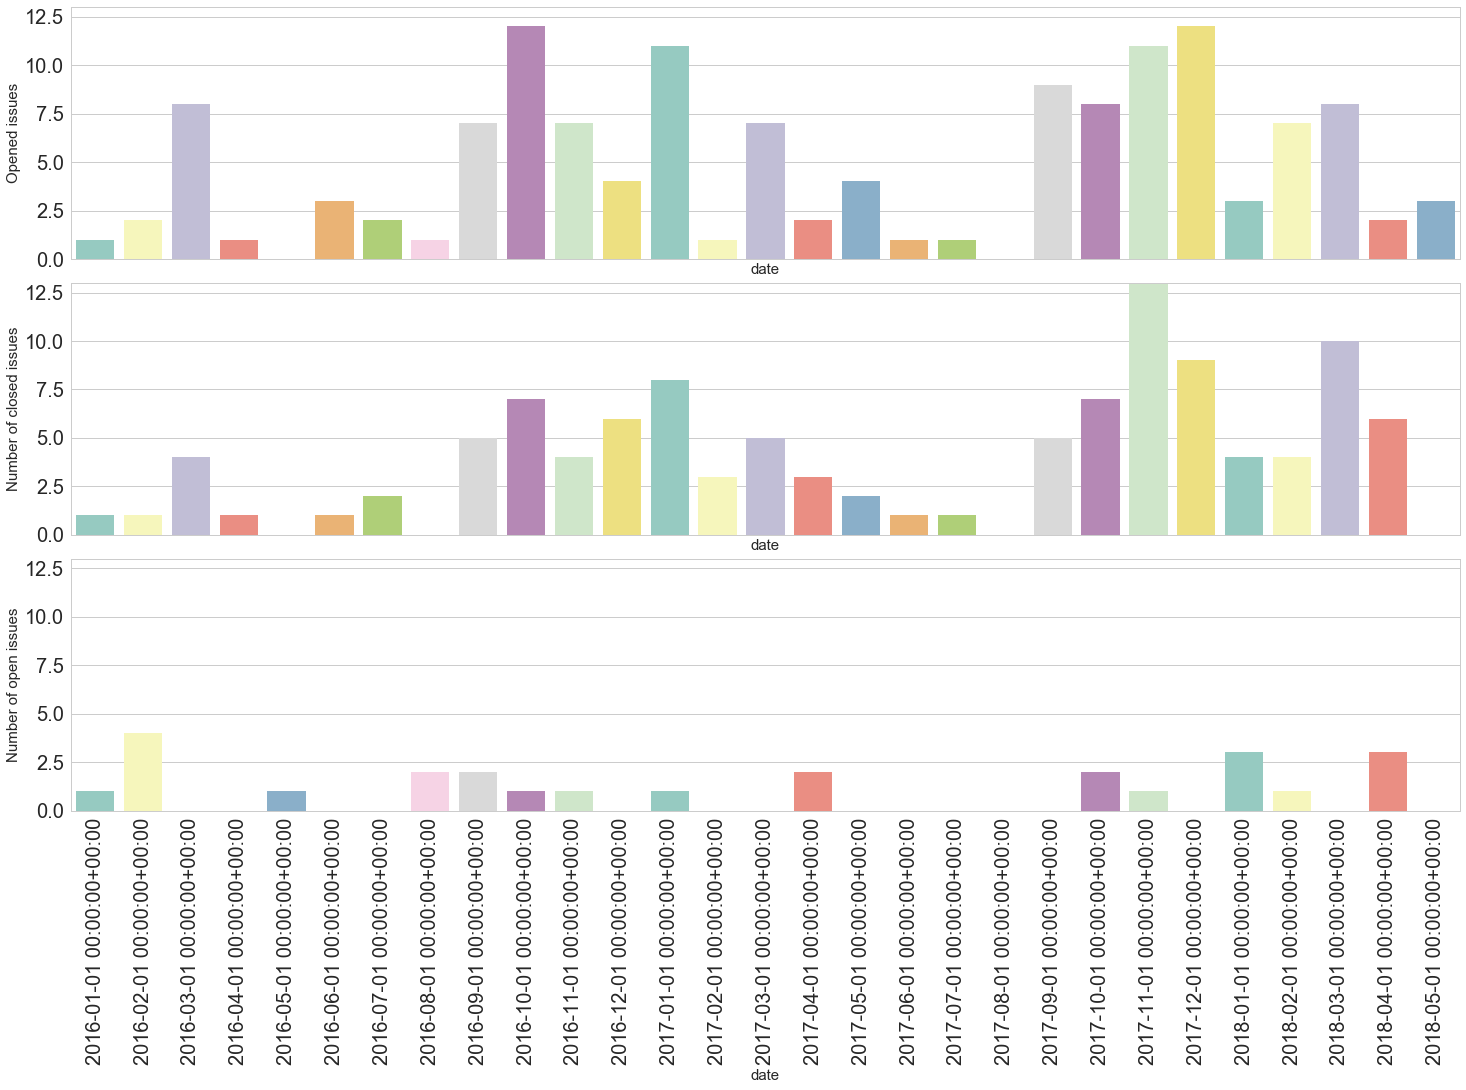

In [41]:
color_scheme = "Set3"
y_limit = max(max(open_issues_by_period_df.value), max(opened_issues_by_period_df.value), 
              max(closed_issues_by_period_df.value))

f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 15), sharex=True)
x = opened_issues_by_period_df['date']

y1 = opened_issues_by_period_df['value']
plot1 = sns.barplot(x, y1, palette=color_scheme, ax=ax1)
ax1.set_ylabel("Opened issues")
ax1.set(ylim=(0, y_limit))

y2 = closed_issues_by_period_df['value']
plot2 = sns.barplot(x, y2, palette=color_scheme, ax=ax2)
ax2.set_ylabel("Number of closed issues")
ax2.set(ylim=(0, y_limit))

y3 = open_issues_by_period_df['value']
plot3 = sns.barplot(x, y3, palette=color_scheme, ax=ax3)
ax3.set_ylabel("Number of open issues")
ax3.set(ylim=(0, y_limit))

plots = [plot1, plot2, plot3]
loc, labels = plt.xticks()
for plot in plots:
    plot.set_xticklabels(labels, rotation=90)
plt.tight_layout(h_pad=3)

## Issues by authors

In [8]:
closed_issues = Issues(github_index)
closed_issues.is_closed()
closed_by_authors = closed_issues.get_cardinality("id_in_repo").by_authors("author_name").fetch_aggregation_results()

opened_issues = Issues(github_index)
opened_by_authors = opened_issues.get_cardinality("id_in_repo").by_authors("author_name").fetch_aggregation_results()

closed_by_author_buckets = closed_by_authors['aggregations']['0']['buckets']
opened_by_author_buckets = opened_by_authors['aggregations']['0']['buckets']

closed_by_author_buckets_df = buckets_to_df(closed_by_author_buckets)
closed_by_author_buckets_df = closed_by_author_buckets_df.rename({"0":"closed_issues"}, axis='columns')
closed_by_author_buckets_df.drop("doc_count", axis=1)
closed_by_author_buckets_df = closed_by_author_buckets_df.set_index("key")


opened_by_author_buckets_df = buckets_to_df(opened_by_author_buckets)
opened_by_author_buckets_df = opened_by_author_buckets_df.rename({"0":"opened_issues"}, axis='columns')
opened_by_author_buckets_df.drop("doc_count",axis=1)
opened_by_author_buckets_df = opened_by_author_buckets_df.set_index("key")

all_issues = pd.merge(opened_by_author_buckets_df, closed_by_author_buckets_df, on="key")

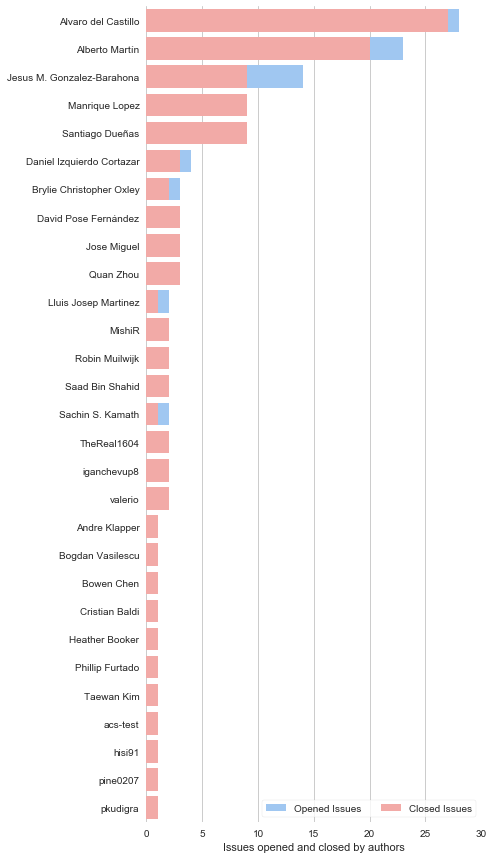

In [13]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="opened_issues", y=all_issues.index, data=all_issues, label="Opened Issues", color="b")
sns.barplot(x="closed_issues", y=all_issues.index, data=all_issues, label="Closed Issues", color="r")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,30), ylabel="", xlabel="Issues opened and closed by authors")
sns.despine(left=True, bottom=True)

<a id="closed_issues"></a>
### open issue age

As per the [discussion here](https://github.com/chaoss/metrics/blob/master/activity-metrics/open-issue-age.md), We'll calculate the percentile, mean, variance and create some visualisations for this metric.

In [15]:
issue = Issues(github_index)
issue.is_open()
percentiles = issue.get_percentile("time_open_days").get_aggs()
print("Percentiles: ", percentiles)

issue.get_extended_stats("time_open_days")
extended_stats = issue.fetch_aggregation_results()['aggregations']['1']
pprint(extended_stats)

Percentiles:  472.7099914550781
{'avg': 428.90999813079833,
 'count': 25,
 'max': 835.75,
 'min': 10.800000190734863,
 'std_deviation': 291.42757593563766,
 'std_deviation_bounds': {'lower': -153.945153740477,
                          'upper': 1011.7651500020736},
 'sum': 10722.749953269958,
 'sum_of_squares': 6722345.462807083,
 'variance': 84930.03201572187}


#### visualizations

In [42]:
# visualisations
time_open_days_issues = Issues(github_index)
time_open_days_issues.is_open()
time_open_days_df = time_open_days_issues.fetch_results_from_source('time_open_days', 'id_in_repo', dataframe=True)
time_open_days_df = time_open_days_df.sort_values("time_open_days", )

### Closed issue resolution duration (Time to resolution of closed issue)

#### percentiles

In [ ]:
closed_issues = Issues(github_index)
closed_issues.is_closed()
percentiles = closed_issues.get_percentile("time_to_close_days").get_aggs()
print("Percentiles: ", percentiles)

closed_issues.get_extended_stats("time_to_close_days")
extended_stats = closed_issues.fetch_aggregation_results()['aggregations']['1']
pprint(extended_stats)

#### Moving average
Moving average: For time to issue resolution, we'll also look at the moving average.

In [ ]:
'''
Example query to get moving average 
{
    "size": 0,
    "aggs": {
        "my_date_histo":{                
            "date_histogram":{
                "field":"created_at",
                "interval":"1M"
            },
            "aggs":{
                "the_sum":{
                    "sum":{ "field": "time_to_close_days" } 
                },
                "the_movavg":{
                    "moving_avg":{ "buckets_path": "the_sum" } 
                }
            }
        }
    }
}
'''
closed_issues = Issues(github_index)
closed_issues.is_closed()
a = A("date_histogram", field="created_at", interval="week")
a.metric("the_sum", "sum", field="time_to_close_days")
a.metric("monthly_moving_average", "moving_avg", buckets_path="the_sum")
closed_issues.add_custom_aggregation(a)
moving_average_for_closed_issues = buckets_to_df(closed_issues.fetch_aggregation_results()['aggregations']['0']['buckets'])

In [ ]:
moving_average_for_closed_issues

#### visualizations

In [ ]:
# visualisations
closed_issues = Issues(github_index)
closed_issues.is_closed()
closed_issue_age = closed_issues.fetch_results_from_source('time_to_close_days', 'id_in_repo', dataframe=True)
print(closed_issue_age)

## Code Development
Goal: Identify how effective the community is at merging new code into the codebase.

Name | Question | Implemented | Issue | PR
--- | --- | --- | --- | --- |
[Code Commits](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-commits.md) | What is the number of code commits? | Yes | None | None
[Lines of Code Changed](https://github.com/chaoss/metrics/tree/master/activity-metrics/lines-of-code-changed.md) | What is the number of lines of code changed? | Yes | None | None
[Code Reviews](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-reviews.md) | What is the number of code reviews?
[Code Merge Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-merge-duration.md) | What is the duration of time between code merge request and code commit?
[Code Review Efficiency](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-review-efficiency.md) | What is the number of merged code changes/number of abandoned code change requests?
[Maintainer Response to Merge Request Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/maintainer-response-to-merge-request-duration.md) | What is the duration of time for a maintainer to make a first response to a code merge request?
[Code Review Iteration](https://github.com/chaoss/metrics/tree/master/activity-metrics/code-review-iteration.md) | What is the number of iterations that occur before a merge request is accepted or declined?
[Forks](https://github.com/chaoss/metrics/tree/master/activity-metrics/forks.md) | Forks are a concept in distributed version control systems like GitHub. It is a proxy for the approximate number of developers who have taken a shot at building and deploying the codebase *for development*.
[Pull Requests Open](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-open.md) | Number of open pull requests. | Yes | None | None | 
[Pull Requests Closed](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-made-closed.md) | Number of closed pull requests. | Yes | None | None |
[Pull Request Comment Duration](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-comment-duration.md) | The difference between the timestamp of the pull request creation date and the most recent comment on the pull request.
[Pull Request Comment Diversity](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-requests-comment-diversity.md) | Number of each people discussing each pull request.
[Pull Request Comments](https://github.com/chaoss/metrics/tree/master/activity-metrics/pull-request-comments.md) | Number of comments on each pull request. 


### code commits

**NOTE:** HERE THE INDEX WILL HAVE TO BE CHANGED

In [ ]:
commits = EQCC(git_index)
commits.get_cardinality("hash")
total_commits = commits.get_aggs()
print("total commits: ", total_commits)

all_commits = commits.fetch_results_from_source("hash", "commit_date")

When you go to the [perceval github repo](https://github.com/chaoss/grimoirelab-perceval), you'll see that actually 1182 commit are present. That maybe because of some empty commit messages. 

#### by months

In [ ]:
buckets_to_df(commits.get_cardinality("hash").by_period().fetch_aggregation_results()['aggregations']['0']['buckets'])

### Lines of code changed

In [ ]:
commits = EQCC(git_index)
lc = commits.get_sum("lines_changed").get_aggs()
la = commits.get_sum("lines_added").get_aggs()
lr = commits.get_sum("lines_removed").get_aggs()

print("Total lines changed: ", lc)
print("Total lines added: ", la)
print("Total lines removed: ", lr)

### Pull requests Open

In [ ]:
open_prs = PullRequests(github_index)
open_prs.is_open()
# get the single valued aggregation before putting it again as a child agg
num_open_prs = open_prs.get_cardinality("id_in_repo").get_aggs() 
open_prs.get_cardinality("id_in_repo").by_authors("author_name")
response = open_prs.fetch_aggregation_results()['aggregations']

In [ ]:
open_prs.aggregations

In [ ]:
print(num_open_prs)

In [ ]:
open_prs_by_authors = response['0']['buckets']
print(buckets_to_df(open_prs_by_authors))

### Pull requests closed

In [ ]:
closed_prs = PullRequests(github_index)
closed_prs.is_closed()
# get the single valued aggregation before putting it again as a child agg
num_closed_prs = closed_prs.get_cardinality("id_in_repo").get_aggs() 
closed_prs.get_cardinality("id_in_repo").by_authors("author_name")
response = closed_prs.fetch_aggregation_results()['aggregations']

In [ ]:
print(num_closed_prs)

In [ ]:
closed_prs_by_authors = response['0']['buckets']
print(buckets_to_df(closed_prs_by_authors))

## Community Growth
Goal: Identify the size of the project community and whether it's growing, shrinking, or staying the same.

Name | Question | Implemented | Issue | PR
--- | --- | --- | --- | --- |
[Contributors](https://github.com/chaoss/metrics/tree/master/activity-metrics/contributors.md) | What is the number of contributors? | Yes | None | None
[New Contributors](https://github.com/chaoss/metrics/tree/master/activity-metrics/new-contributors.md) | What is the number of new contributors? | Yes | None | None
[Contributing Organizations](https://github.com/chaoss/metrics/tree/master/activity-metrics/contributing-organizations.md) | What is the number of contributing organizations? | Yes | None | None
[New Contributing Organizations](https://github.com/chaoss/metrics/tree/master/activity-metrics/new-contributing-organizations.md) | What is the number of new contributing organizations?
[Sub-Projects](https://github.com/chaoss/metrics/tree/master/activity-metrics/sub-projects.md) | What is the number of sub-projects?

### Number of contributors

In [ ]:
contributors = EQCC(git_index)
contributors.get_sum("lines_changed").by_authors("author_name")
contributors.get_sum("lines_added").by_authors("author_name")
contributors.get_sum("lines_removed").by_authors("author_name")
contributors.get_average("files").by_authors("author_name")
contributors.get_cardinality("author_uuid")

In [ ]:
# maybe a pie chart showing the different users and the magnitude of their contributions is the total number of lines changed/removed/added??

buckets_to_df(contributors.fetch_aggregation_results()['aggregations']['0']['buckets'])

### New contributors

For new contributors, we have to get the names and counts of the people who made commits to the project. [This](https://grimoirelab.gitbooks.io/tutorial/python/pandas-for-grimoirelab-indexes.html) tutorial of Grimoirelab actually gets the dates on which the authors made their first commits. Based on that we can get the months when the authors made their first commits and those authors will be the new authors for that month. We can do a similar thing for Year. (We can also get the authors by week, but there is little point in calculating that and it will be complex to calculate that too.)

In [ ]:
# new contributors by month
new_contributors = EQCC(git_index)
new_contributors.get_min("author_date").by_authors("author_name")
response = new_contributors.fetch_aggregation_results()
buckets = response['aggregations']['0']['buckets']
print(buckets)

### Contributing Organizations

In [ ]:
github_index = Index("aima_github")
contributing_orgs = EQCC(github_index)
contributing_orgs.get_terms("user_org")
response = contributing_orgs.fetch_aggregation_results()
buckets = response['aggregations']['0']['buckets']
organizations = pd.Series([item['key'] for item in buckets])
print(organizations)


In [ ]:
organizations = EQCC(github_index)
organizations.get_terms("author_name").by_organizations("user_orgs")
response = organizations.fetch_aggregation_results()
buckets = response['aggregations']['0']['buckets']
pprint(buckets)
